# EDA Raman Spectra

Этот ноутбук выполняет базовый анализ спектров:
- загрузка данных (здоровые / больные),
- сводка по размерам,
- средние спектры,
- PCA визуализация.


In [31]:
# параметры
file_path = "Raman_krov_SSZ-zdorovye.xlsx"  # путь к файлу

In [32]:
import pandas as pd
import numpy as np

df_health = pd.read_excel(file_path, sheet_name="health")
df_disease = pd.read_excel(file_path, sheet_name="heart disease")

wavenumber = df_health["wavenumber"].values
X_health = df_health.drop(columns=["wavenumber"]).T.values
X_disease = df_disease.drop(columns=["wavenumber"]).T.values

print("Healthy shape:", X_health.shape)
print("Disease shape:", X_disease.shape)
print("Wavenumber points:", len(wavenumber))

Healthy shape: (50, 2000)
Disease shape: (50, 2000)
Wavenumber points: 2000


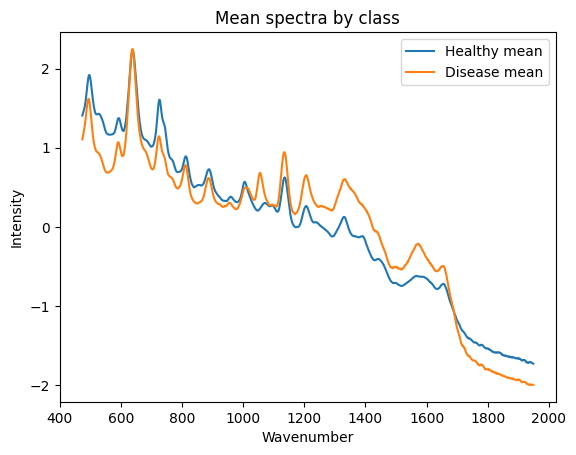

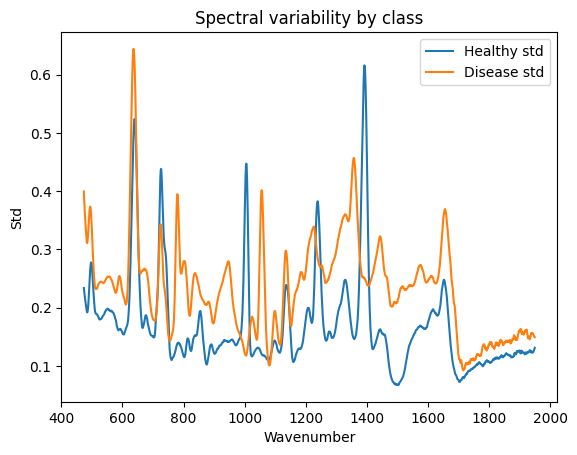

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(wavenumber, X_health.mean(axis=0), label="Healthy mean")
plt.plot(wavenumber, X_disease.mean(axis=0), label="Disease mean")
plt.legend(); plt.xlabel("Wavenumber"); plt.ylabel("Intensity")
plt.title("Mean spectra by class")
plt.show()

plt.figure()
plt.plot(wavenumber, X_health.std(axis=0), label="Healthy std")
plt.plot(wavenumber, X_disease.std(axis=0), label="Disease std")
plt.legend(); plt.xlabel("Wavenumber"); plt.ylabel("Std")
plt.title("Spectral variability by class")
plt.show()

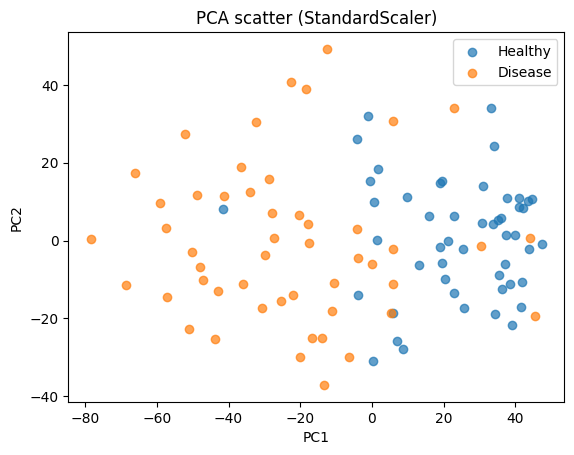

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = np.vstack([X_health, X_disease])
y = np.array([0]*X_health.shape[0] + [1]*X_disease.shape[0])

Xn = StandardScaler().fit_transform(X)
Z = PCA(n_components=2, random_state=42).fit_transform(Xn)

plt.figure()
plt.scatter(Z[y==0,0], Z[y==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z[y==1,0], Z[y==1,1], label="Disease", alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend()
plt.title("PCA scatter (StandardScaler)")
plt.show()

между здоровыми и больными пациентами: наблюдается тенденция к смещению здоровых образцов вправо вдоль оси PC1. Однако значительное перекрытие классов и наличие выбросов указывает на то, что линейных методов сжатия признаков недостаточно для надёжной классификации, и требуется применение более сложных моделей

СКОЛЬЗЯЩЕЕ СРЕДНЕЕ + ОТНОШЕНИЕ СИГНАЛ-ШУМ (С/Ш)

In [35]:
def moving_average(x, k=11):
    """Простое скользящее среднее (для сглаживания)"""
    k = max(3, int(k) | 1)  # делаем нечётное окно >=3
    pad = k // 2
    xpad = np.pad(x, (pad, pad), mode="edge")
    ker = np.ones(k) / k
    return np.convolve(xpad, ker, mode="valid")

def estimate_snr_per_spectrum(x, smooth_win=31):
    """
    Оценка SNR: 
    отношение мощности сглаженного сигнала к шуму (остаток).
    """
    s = moving_average(x, k=smooth_win)
    noise = x - s
    rms_signal = np.sqrt(np.mean(s**2))
    std_noise = np.std(noise)
    return np.inf if std_noise == 0 else rms_signal / std_noise

# Считаем SNR для всех спектров
snr = np.array([estimate_snr_per_spectrum(row, smooth_win=31) for row in X])


ВИЗУАЛИЗАЦИЯ С/Ш

C:\Users\nastk\AppData\Local\Temp\ipykernel_1612\207757908.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([snr[y==0], snr[y==1]], labels=["Healthy", "Heart disease"], showfliers=True)


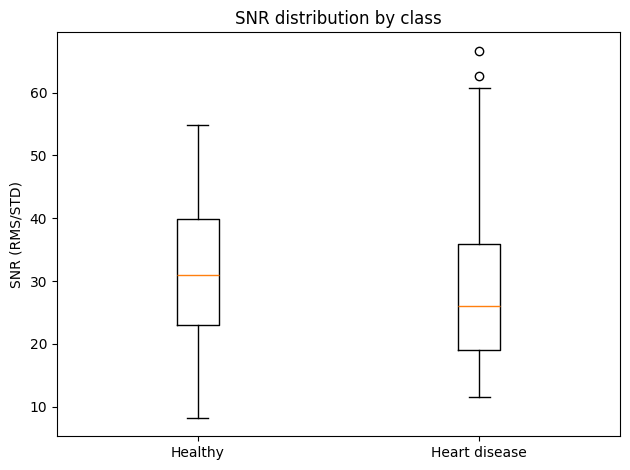

In [36]:
plt.figure()
plt.boxplot([snr[y==0], snr[y==1]], labels=["Healthy", "Heart disease"], showfliers=True)
plt.ylabel("SNR (RMS/STD)")
plt.title("SNR distribution by class")
plt.tight_layout()
plt.show()


проведём тесты на нормальность распределения и статистически значимую разницу в значениях С/Ш между здоровыми ибольными пациентами

Healthy  - mean: 31.84854903093279  median: 30.93450248490306
Disease  - mean: 29.144922687284843  median: 26.101263325119056

Shapiro-Wilk p-values: Healthy = 0.4641879750286354 , Disease = 0.0009762053314537459

Mann–Whitney U-test: U = 1490.0 , p-value = 0.09872431079247232


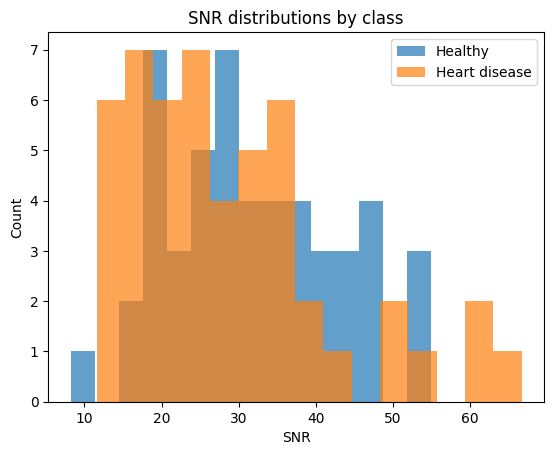

In [37]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Разделяем SNR по классам
snr_healthy = snr[y == 0]
snr_disease = snr[y == 1]

# Быстрая статистика
print("Healthy  - mean:", np.mean(snr_healthy), " median:", np.median(snr_healthy))
print("Disease  - mean:", np.mean(snr_disease), " median:", np.median(snr_disease))

# Тест на нормальность (Shapiro-Wilk)
sh_healthy = stats.shapiro(snr_healthy)
sh_disease = stats.shapiro(snr_disease)
print("\nShapiro-Wilk p-values: Healthy =", sh_healthy.pvalue, ", Disease =", sh_disease.pvalue)

# Тест на равенство распределений (Mann–Whitney U)
u_test = stats.mannwhitneyu(snr_healthy, snr_disease, alternative="two-sided")
print("\nMann–Whitney U-test: U =", u_test.statistic, ", p-value =", u_test.pvalue)

# Визуализация — гистограммы
plt.hist(snr_healthy, bins=15, alpha=0.7, label="Healthy")
plt.hist(snr_disease, bins=15, alpha=0.7, label="Heart disease")
plt.xlabel("SNR"); plt.ylabel("Count")
plt.legend(); plt.title("SNR distributions by class")
plt.show()


В среднем спектры у больных имеют немного более низкий SNR, чем у здоровых (медиана 26 против 31), однако статистический тест (Mann–Whitney U, p≈0.099) не показал значимой разницы.
Таким образом, различия в качестве спектров не являются критическими и шум присутствует в обеих группах. Это подчёркивает необходимость стандартного этапа предобработки данных

сделаем чистку данных от тех, в которых С/Ш меньше 15, для лучшей подготовки датасета к последующему обучению

In [38]:
# --- Удаление спектров с низким SNR ---
snr_threshold = 15  # можно менять (например, 10 / 15 / 20)
mask = snr >= snr_threshold

X_clean = X[mask]
y_clean = y[mask]
wavenumber_clean = wavenumber  # ось остаётся та же
snr_clean = snr[mask]

print(f"Исходный размер: {X.shape[0]} спектров")
print(f"После фильтрации (SNR >= {snr_threshold}): {X_clean.shape[0]} спектров")
print(f"Удалено: {X.shape[0] - X_clean.shape[0]} спектров")

# --- Сохраняем в CSV для дальнейшего использования ---
import pandas as pd

pd.DataFrame(X_clean).to_csv("X_clean.csv", index=False)
pd.DataFrame({"label": y_clean, "snr": snr_clean}).to_csv("y_clean.csv", index=False)
pd.DataFrame({"wavenumber": wavenumber_clean}).to_csv("wavenumber.csv", index=False)


Исходный размер: 100 спектров
После фильтрации (SNR >= 15): 94 спектров
Удалено: 6 спектров


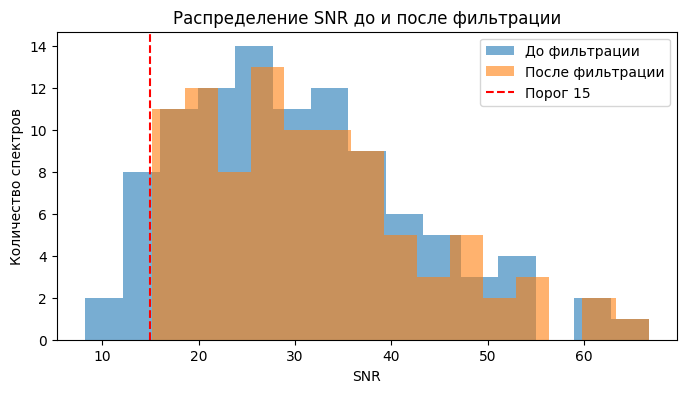

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.hist(snr, bins=15, alpha=0.6, label="До фильтрации")
plt.hist(snr_clean, bins=15, alpha=0.6, label="После фильтрации")
plt.axvline(snr_threshold, color="red", linestyle="--", label=f"Порог {snr_threshold}")

plt.xlabel("SNR")
plt.ylabel("Количество спектров")
plt.title("Распределение SNR до и после фильтрации")
plt.legend()
plt.show()


после фильтрации мы можем видеть на графике отношения С/Ш пороговое ограничение в 15 единиц, что дает нам большее качество данных для обучения модели

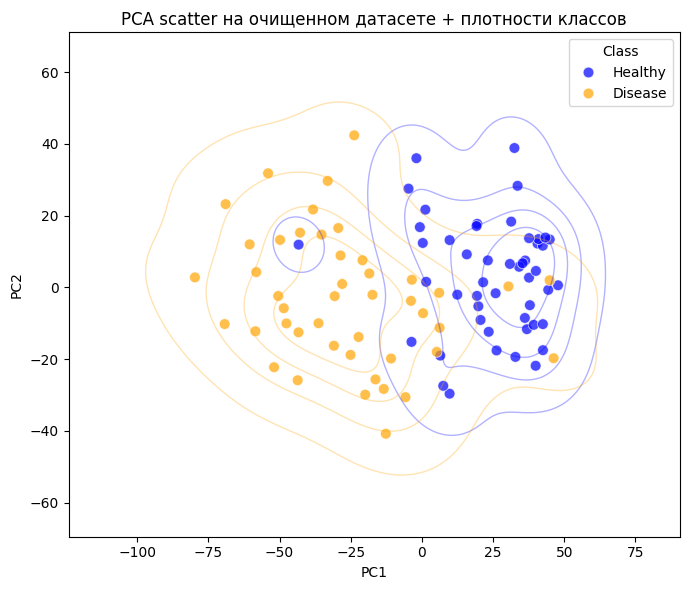

Доля объяснённой дисперсии: [0.58963598 0.1443405 ]


In [40]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Нормализация и PCA для очищенного датасета
Xn_clean = StandardScaler().fit_transform(X_clean)
pca_clean = PCA(n_components=2, random_state=42)
Z_clean = pca_clean.fit_transform(Xn_clean)

# График с точками
plt.figure(figsize=(7,6))
sns.scatterplot(x=Z_clean[:,0], y=Z_clean[:,1],
                hue=["Healthy" if cls==0 else "Disease" for cls in y_clean],
                palette={"Healthy":"blue","Disease":"orange"},
                alpha=0.7, s=60)

# Добавляем контурные линии плотности для наглядности
sns.kdeplot(x=Z_clean[y_clean==0,0], y=Z_clean[y_clean==0,1],
            levels=5, color="blue", alpha=0.3, linewidths=1)
sns.kdeplot(x=Z_clean[y_clean==1,0], y=Z_clean[y_clean==1,1],
            levels=5, color="orange", alpha=0.3, linewidths=1)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA scatter на очищенном датасете + плотности классов")
plt.legend(title="Class")
plt.tight_layout()
plt.show()

print("Доля объяснённой дисперсии:", pca_clean.explained_variance_ratio_)


Классы частично разделяются вдоль PC1, но сильно перекрываются.
Это значит, что основные линейные различия в спектрах связаны с заболеванием, но они не доминируют над общей вариабельностью

c:\Users\nastk\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


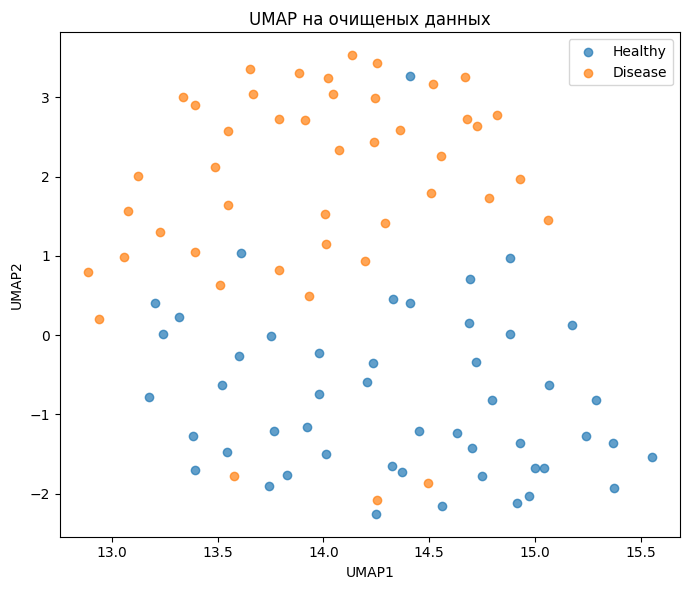

In [41]:
import umap
import matplotlib.pyplot as plt

# Нормализация (можно взять X_clean и y_clean)
from sklearn.preprocessing import StandardScaler
Xn_umap = StandardScaler().fit_transform(X_clean)

# UMAP в 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
Z_umap = umap_model.fit_transform(Xn_umap)

# Визуализация
plt.figure(figsize=(7,6))
plt.scatter(Z_umap[y_clean==0,0], Z_umap[y_clean==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z_umap[y_clean==1,0], Z_umap[y_clean==1,1], label="Disease", alpha=0.7)
plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
plt.title("UMAP на очищеных данных")
plt.legend()
plt.tight_layout()
plt.show()

Группы Healthy и Disease разделены более явно.
Это указывает, что нелинейные зависимости в данных помогают лучше выделить классы

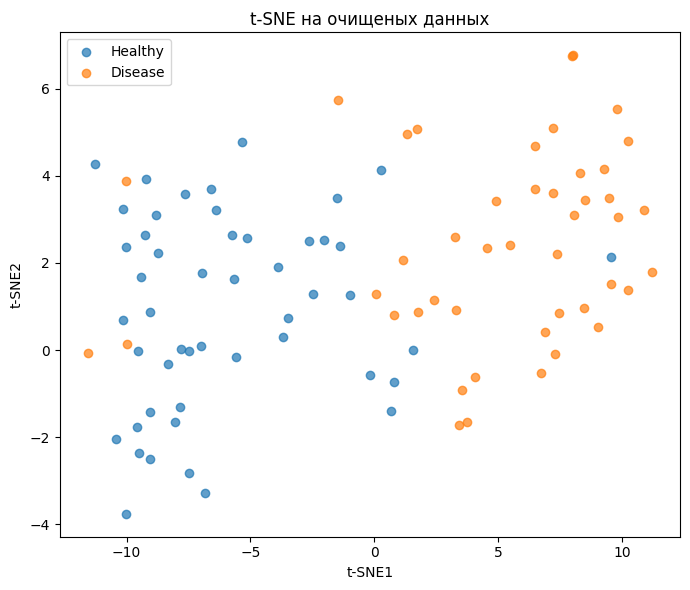

In [42]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Нормализация
Xn_tsne = StandardScaler().fit_transform(X_clean)

# t-SNE проекция в 2D
tsne_model = TSNE(n_components=2, perplexity=20, random_state=42, max_iter=1000)
Z_tsne = tsne_model.fit_transform(Xn_tsne)

# Визуализация
plt.figure(figsize=(7,6))
plt.scatter(Z_tsne[y_clean==0,0], Z_tsne[y_clean==0,1], label="Healthy", alpha=0.7)
plt.scatter(Z_tsne[y_clean==1,0], Z_tsne[y_clean==1,1], label="Disease", alpha=0.7)
plt.xlabel("t-SNE1"); plt.ylabel("t-SNE2")
plt.title("t-SNE на очищеных данных")
plt.legend()
plt.tight_layout()
plt.show()



Healthy и Disease формируют разные кластеры.
Значит, спектры действительно содержат скрытые нелинейные паттерны, которые линейные методы (PCA) не улавливают

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np

# функция для оценки AUC через кросс-валидацию
def evaluate_auc(Z, y, name):
    clf = LogisticRegression(max_iter=2000)
    scores = cross_val_score(clf, Z, y, cv=5, scoring="roc_auc")
    print(f"{name} — mean AUC: {np.mean(scores):.3f} ± {np.std(scores):.3f}")

# PCA (2D)
evaluate_auc(Z_clean, y_clean, "PCA (2D)")

# UMAP (2D)
evaluate_auc(Z_umap, y_clean, "UMAP (2D)")

# t-SNE (2D)
evaluate_auc(Z_tsne, y_clean, "t-SNE (2D)")


PCA (2D) — mean AUC: 0.940 ± 0.048
UMAP (2D) — mean AUC: 0.935 ± 0.051
t-SNE (2D) — mean AUC: 0.916 ± 0.069


Оценка ROC-AUC логистической регрессии на признаках, полученных после снижения размерности, показала, что линейный метод PCA обеспечивает не хуже, а в нашем случае даже лучшее качество классификации (AUC ~0.94), чем нелинейные методы UMAP и t-SNE. Это говорит о том, что существенная часть информации о различии классов содержится в линейных комбинациях спектральных признаков. Тем не менее, наличие частичного перекрытия классов и нелинейных структур в данных указывает на перспективность применения более сложных моделей (например, нейронных сетей), которые смогут использовать как линейные, так и нелинейные закономерности